## LASSO问题的梯度下降法

### LASSO问题
<p>Lasso是Least Absolute Shrinkage and Selection Operator的简称，是一种采用了L1正则化（L1-regularization)的线性回归方法，采用了L1正则会使得部分学习到的特征权值为0，从而达到稀疏化和特征选择的目的。</p>
<b>LASSO & Ridge Regression(岭回归)<b/>
<p>* LASSO:  L1 正则</p>
<p>* Ridge Regression： L2 正则</p>


### 一、 LASSO 问题的 Huber 光滑化梯度法

考虑LASSO问题
$$
\displaystyle\min_x \frac{1}{2}\|Ax-b\|_2^2 + \mu \|x\|_1.
$$
由于目标函数的不光滑性，在某些点处无法求出梯度，因此不能直接对原始问题使用梯度法求解。
<p>这里考虑一维光滑函数：</p>
$$
\displaystyle\ell_\sigma(x)=\left\{
\begin{array}{ll}
\frac{1}{2\sigma}x^2, & |x|<\sigma; \\
|x|-\frac{\sigma}{2}, & \mathrm{otherwise}.
\end{array} \right.
$$
使用 $\displaystyle L_\sigma(x)=\sum_{i=1}^n\ell_\sigma(x_i)$ 替代 $\|x\|_1$，得到如下优化问题：
$$
\displaystyle\min_x f(x) := \frac{1}{2}\|Ax-b\|_2^2 + \mu L_{\sigma}(x).
$$
在 x点处 f的梯度为：
$$
\displaystyle\nabla f(x)=A^\top (Ax-b)+\mu\nabla L_{\sigma}(x),
$$
其中
$$
\displaystyle(\nabla L_{\sigma}(x))_i=\left\{ \begin{array}{ll}
\mathrm{sign}(x_i), & |x_i|>\sigma; \\
\frac{x_i}{\sigma}, & |x_i|\le\sigma.
\end{array} \right.
$$
可以直接利用带BB步长的梯度下降法最小化 f来得到原问题解的一个近似解（解的质量与 σ 选取有关）。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
opts = {'maxit': 200, 'ftol': 1e-8, 'gtol': 1e-6, 'alpha0': 0.01, 
           'sigma': 0.1, 'verbose': 0}

'''
opts.maxit ：最大迭代次数
opts.ftol ：针对函数值的停机准则，当相邻两次迭代函数值之差小于该值时认为该条件满足
opts.gtol ：针对梯度的停机准则，当当前步梯度范数小于该值时认为该条件满足
opts.alpha0 ：步长的初始值
opts.sigma ：Huber 光滑化参数 σ
opts.verbose ：不为 0 时输出每步迭代信息，否则不输出
'''

'\nopts.maxit ：最大迭代次数\nopts.ftol ：针对函数值的停机准则，当相邻两次迭代函数值之差小于该值时认为该条件满足\nopts.gtol ：针对梯度的停机准则，当当前步梯度范数小于该值时认为该条件满足\nopts.alpha0 ：步长的初始值\nopts.sigma ：Huber 光滑化参数 σ\nopts.verbose ：不为 0 时输出每步迭代信息，否则不输出\n'

In [2]:
def LASSO_grad_huber_inn(x, A, b, mu, mu0, opt):
    for i in opts.keys():
        if opt.get(i, -1) == -1:
            opt[i] = opts[i]
    tic = time.time()
    r = np.matmul(A, x) - b
    g = np.matmul(A.T, r)
    huber_g = np.sign(x)
    idx = abs(x) < opt['sigma']
    huber_g[idx] = x[idx] / opt['sigma']
    
    g = g + mu * huber_g
    nrmG= np.linalg.norm(g, 2)
    
    f = 0.5 * np.linalg.norm(r, 2) ** 2 + \
                mu * (np.sum(np.square(x[idx])/(2 * opt['sigma'])) \
                      + np.sum(np.abs(x[abs(x) >= opt['sigma']]) - \
                               opt['sigma'] / 2))
    out = {}
    
    out['fvec'] = 0.5 * np.linalg.norm(r, 2) ** 2 + mu0 * np.linalg.norm(x, 1)
    alpha = opt['alpha0']
    eta = 0.2
    
    rhols = 1e-6
    gamma = 0.85
    Q = 1
    Cval = f
    for k in range(opt['maxit']):
        fp = f
        gp = g
        xp = x
        nls = 1
        while 1:
            x = xp - alpha * gp
            r = np.dot(A, x) - b
            g = np.dot(A.T, r)
            huber_g = np.sign(x)
            idx = abs(x) < opt['sigma']
            huber_g[idx] = x[idx] / opt['sigma']
            f = 0.5 * np.linalg.norm(r, 2) ** 2 + \
                mu * (np.sum(x[abs(x) >= opt['sigma']] - opt['sigma'] / 2))
            g = g + mu * huber_g
            if f <= Cval - alpha * rhols * nrmG ** 2 or nls >= 10:
                break
            alpha = eta * alpha 
            nls += 1
        nrmG = np.linalg.norm(g, 2)
        forg = 0.5 * np.linalg.norm(r, 2) ** 2 + mu0 * np.linalg.norm(x, 1)
        out['fvec'] = [out['fvec'], forg]
        if opt['verbose']:
            print('%4d\t %.4e \t %.1e \t %.2e \t %2d \n'%(k, f, nrmG, alpha, nls))
        if nrmG < opt['gtol'] or abs(fp - f) < opt['ftol']:
            break
        dx = x - xp
        xg = g - gp
        dxg = abs(np.matmul(dx.T, dx))
        if dxg > 0:
            if k % 2 == 0:
                alpha = np.matmul(dx.T, dx) / dxg
            else:
                alpha = dxg / np.matmul(dg.T, dg)
            alpha = max(min(alpha, 1e12), 1e-12)
        Qp = Q
        Q = gamma * Qp + 1
        Cval = (gamma * Qp * Cval + f) / Q
    out['flag'] = k == opt['maxit']
    out['fval'] = f
    out['itr'] = k
    out['tt'] = time.time() - tic
    out['nrmG'] = nrmG
    return [x, out]

### LASSO问题的连续化策略

连续化策略从较大的正则化参数 μt 逐渐减小到 μ0（即 μ1≥⋯≥μt−1≥μt≥⋯≥μ0），并求解相应的 LASSO 问题：
$$
\min_x \frac{1}{2}\|Ax-b\|_2^2 + \mu_t \|x\|_1.
$$
这样做的好处是：在求解 μt 对应的优化问题时，可以利用 μt−1 对应优化问题的解（ μ1 子问题使用随机初始点）作为 一个很好的逼近解以在较短的时间内完成求解过程； 分析可知 μt 越大，相应的 LASSO 问题越好解。因此， 连续化策略相当于是通过快速求解一系列简单问题（复杂问题有了好的初始解也就变简单了）来加速求解原始问题。
$$
这里，在调用迭代算法求解 μ_t 对应的 LASSO 问题后，正则化参数 μ_t+1 的更新公式取为：
$$
$$
\displaystyle \mu_{t+1} = \max \{ \mu_0, \mu_t \eta \},
$$

In [3]:
import time
import numpy as np

optsp = {'maxit': 30, 'maxit_inn':1, 'ftol': 1e-8, 'gtol': 1e-6, 
        'factor': 0.1, 'verbose': 1, 'mul': 100, 'opts1':{},
        'etaf': 1e-1, 'etag': 1e-1}
optsp['gtol_init_ratio'] = 1 / optsp['gtol']
optsp['ftol_init_ratio'] = 1e5
def prox(x, mu):
    y = np.max(np.abs(x) - mu, 0)
    y = np.dot(np.sign(x), y)
    return y
def Func(A, b, mu0, x):
    w = np.dot(A, x) - b
    f = 0.5 * (np.matmul(w.T, w)) + mu0 * np.linalg.norm(x, 1)
    return f
def LASSO_con(x0, A, b, mu0, opts):
    L = max(np.linalg.eig(np.matmul(A.T, A))[0])
    for i in optsp.keys():
        if opts.get(i, -1) == -1:
            opts[i] = optsp[i]
    if not opts['alpha0']: opts['alpha0'] = 1 / L
    out = {}
    out['fvec'] = []
    k = 0
    x = x0
    mu_t = opts['mul']
    tic = time.time()
    f = Func(A, b, mu_t, x)
    opts1 = opts['opts1']
    opts1['ftol'] = opts['ftol'] * opts['ftol_init_ratio']
    opts1['gtol'] = opts['gtol'] * opts['gtol_init_ratio']
    out['itr_inn'] = 0
    while k < opts['maxit']:
        opts1['maxit'] = opts['maxit_inn']
        opts1['gtol'] = max(opts1['gtol'] * opts['etag'], opts['gtol'])
        opts1['ftol'] = max(opts1['ftol'] * opts['etaf'], opts['ftol'])
        opts1['verbose'] = opts['verbose'] > 1
        opts1['alpha0'] = opts['alpha0']
        if opts['method'] == 'grad_huber':
            opts1['sigma'] = 1e-3 * mu_t
        fp = f
        [x, out1] = LASSO_grad_huber_inn(x, A, b, mu_t, mu0, opts1)
        f = out1['fvec'][-1]
        out['fvec'].extend(out1['fvec'])# = [out['fvec'], out1['fvec']]
        k += 1
        nrmG = np.linalg.norm(x - prox(x - np.matmul(A.T, (np.matmul(A, x) - b)), mu0),2)
        if opts['verbose']:
            print('itr: %d\tmu_t: %e\titr_inn: %d\tfval: %e\tnrmG: %.1e\n'%(k, mu_t, out1['itr'], f, nrmG))
        if not out1['flag']:
            mu_t = max(mu_t * opts['factor'], mu0)
        if mu_t == mu0 and (nrmG < opts['gtol'] or abs(f - fp) < opts['ftol']):
            break
        out['itr_inn'] = out['itr_inn'] + out1['itr']
    out['fval'] = f
    out['tt'] = time.time() - tic
    out['itr'] = k
    return [x, out]

### Huber 光滑化梯度法的应用

In [4]:
import random
import numpy as np
import scipy.sparse
random.seed(97006855)

m = 512
n = 1024
A = np.random.randn(m, n)
u = scipy.sparse.rand(n,1,0.1).toarray()
b = np.dot(A, u)


L = max(np.linalg.eig(np.matmul(A.T, A))[0])
x0 = np.random.randn(n, 1)

mu = 1e-3
opts = {'method': 'grad_huber', 'verbose': 1, 'maxit': 100, 
       'ftol': 1e-8, 'alpha0': 1 / L}
[x, out] = LASSO_con(x0, A, b, mu, opts)
f_star = min(out['fvec'])
opts['verbose'] = 1
opts['maxit'] = 100
if opts['verbose']:
    print('mu = 1e-3\n')
[x, out] = LASSO_con(x0, A, b, mu, opts)
data1 = (np.array(out['fvec']) - f_star) / f_star
k1 = min(len(data1), 100)
data1 = data1[1:k1]

mu = 1e-2
opts = {'method': 'grad_huber', 'verbose': 1, 'maxit': 100, 
        'ftol': 1e-8, 'alpha0': 1 / L}
[x, out] = LASSO_con(x0, A, b, mu, opts)
f_star = min(out['fvec'])
opts['verbose'] = 1
opts['maxit'] = 100
if opts['verbose']:
    print('\n mu = 1e-2 \n')
[x, out] = LASSO_con(x0, A, b, mu, opts)
data2 = (np.array(out['fvec']) - f_star) / f_star
k2 = min(len(data2), 100)
data2 = data2[1:k2]


itr: 1	mu_t: 1.000000e+02	itr_inn: 0	fval: 8.039190e+04	nrmG: 1.3e+06

itr: 2	mu_t: 1.000000e+01	itr_inn: 0	fval: 4.078615e+04	nrmG: 8.0e+05

itr: 3	mu_t: 1.000000e+00	itr_inn: 0	fval: 2.489515e+04	nrmG: 5.6e+05

itr: 4	mu_t: 1.000000e-01	itr_inn: 0	fval: 1.672274e+04	nrmG: 4.1e+05

itr: 5	mu_t: 1.000000e-02	itr_inn: 0	fval: 1.192497e+04	nrmG: 3.1e+05

itr: 6	mu_t: 1.000000e-03	itr_inn: 0	fval: 8.862242e+03	nrmG: 2.6e+05

itr: 7	mu_t: 1.000000e-03	itr_inn: 0	fval: 6.789820e+03	nrmG: 2.2e+05

itr: 8	mu_t: 1.000000e-03	itr_inn: 0	fval: 5.325604e+03	nrmG: 1.9e+05

itr: 9	mu_t: 1.000000e-03	itr_inn: 0	fval: 4.255864e+03	nrmG: 1.6e+05

itr: 10	mu_t: 1.000000e-03	itr_inn: 0	fval: 3.453103e+03	nrmG: 1.4e+05

itr: 11	mu_t: 1.000000e-03	itr_inn: 0	fval: 2.837353e+03	nrmG: 1.2e+05

itr: 12	mu_t: 1.000000e-03	itr_inn: 0	fval: 2.356379e+03	nrmG: 1.1e+05

itr: 13	mu_t: 1.000000e-03	itr_inn: 0	fval: 1.974881e+03	nrmG: 9.7e+04

itr: 14	mu_t: 1.000000e-03	itr_inn: 0	fval: 1.668308e+03	nrmG: 8.8e+04

i

itr: 15	mu_t: 1.000000e-03	itr_inn: 0	fval: 1.419156e+03	nrmG: 7.9e+04

itr: 16	mu_t: 1.000000e-03	itr_inn: 0	fval: 1.214674e+03	nrmG: 7.2e+04

itr: 17	mu_t: 1.000000e-03	itr_inn: 0	fval: 1.045396e+03	nrmG: 6.6e+04

itr: 18	mu_t: 1.000000e-03	itr_inn: 0	fval: 9.041808e+02	nrmG: 6.1e+04

itr: 19	mu_t: 1.000000e-03	itr_inn: 0	fval: 7.855633e+02	nrmG: 5.5e+04

itr: 20	mu_t: 1.000000e-03	itr_inn: 0	fval: 6.853058e+02	nrmG: 5.1e+04

itr: 21	mu_t: 1.000000e-03	itr_inn: 0	fval: 6.000865e+02	nrmG: 4.7e+04

itr: 22	mu_t: 1.000000e-03	itr_inn: 0	fval: 5.272747e+02	nrmG: 4.3e+04

itr: 23	mu_t: 1.000000e-03	itr_inn: 0	fval: 4.647684e+02	nrmG: 4.0e+04

itr: 24	mu_t: 1.000000e-03	itr_inn: 0	fval: 4.108740e+02	nrmG: 3.7e+04

itr: 25	mu_t: 1.000000e-03	itr_inn: 0	fval: 3.642166e+02	nrmG: 3.5e+04

itr: 26	mu_t: 1.000000e-03	itr_inn: 0	fval: 3.236725e+02	nrmG: 3.3e+04

itr: 27	mu_t: 1.000000e-03	itr_inn: 0	fval: 2.883175e+02	nrmG: 3.1e+04

itr: 28	mu_t: 1.000000e-03	itr_inn: 0	fval: 2.573871e+02	nrmG: 2

itr: 29	mu_t: 1.000000e-02	itr_inn: 0	fval: 2.352135e+02	nrmG: 2.7e+04

itr: 30	mu_t: 1.000000e-02	itr_inn: 0	fval: 2.113301e+02	nrmG: 2.5e+04

itr: 31	mu_t: 1.000000e-02	itr_inn: 0	fval: 1.902566e+02	nrmG: 2.4e+04

itr: 32	mu_t: 1.000000e-02	itr_inn: 0	fval: 1.716157e+02	nrmG: 2.2e+04

itr: 33	mu_t: 1.000000e-02	itr_inn: 0	fval: 1.550877e+02	nrmG: 2.1e+04

itr: 34	mu_t: 1.000000e-02	itr_inn: 0	fval: 1.404008e+02	nrmG: 2.0e+04

itr: 35	mu_t: 1.000000e-02	itr_inn: 0	fval: 1.273230e+02	nrmG: 1.9e+04

itr: 36	mu_t: 1.000000e-02	itr_inn: 0	fval: 1.156551e+02	nrmG: 1.7e+04

itr: 37	mu_t: 1.000000e-02	itr_inn: 0	fval: 1.052260e+02	nrmG: 1.6e+04

itr: 38	mu_t: 1.000000e-02	itr_inn: 0	fval: 9.588788e+01	nrmG: 1.6e+04

itr: 39	mu_t: 1.000000e-02	itr_inn: 0	fval: 8.751306e+01	nrmG: 1.5e+04

itr: 40	mu_t: 1.000000e-02	itr_inn: 0	fval: 7.999053e+01	nrmG: 1.4e+04

itr: 41	mu_t: 1.000000e-02	itr_inn: 0	fval: 7.322368e+01	nrmG: 1.3e+04

itr: 42	mu_t: 1.000000e-02	itr_inn: 0	fval: 6.712805e+01	nrmG: 1

itr: 43	mu_t: 1.000000e-02	itr_inn: 0	fval: 6.162989e+01	nrmG: 1.2e+04

itr: 44	mu_t: 1.000000e-02	itr_inn: 0	fval: 5.666448e+01	nrmG: 1.1e+04

itr: 45	mu_t: 1.000000e-02	itr_inn: 0	fval: 5.217500e+01	nrmG: 1.1e+04

itr: 46	mu_t: 1.000000e-02	itr_inn: 0	fval: 4.811133e+01	nrmG: 1.0e+04

itr: 47	mu_t: 1.000000e-02	itr_inn: 0	fval: 4.442914e+01	nrmG: 9.9e+03

itr: 48	mu_t: 1.000000e-02	itr_inn: 0	fval: 4.108923e+01	nrmG: 9.5e+03

itr: 49	mu_t: 1.000000e-02	itr_inn: 0	fval: 3.805690e+01	nrmG: 9.1e+03

itr: 50	mu_t: 1.000000e-02	itr_inn: 0	fval: 3.530137e+01	nrmG: 8.7e+03

itr: 51	mu_t: 1.000000e-02	itr_inn: 0	fval: 3.279518e+01	nrmG: 8.3e+03

itr: 52	mu_t: 1.000000e-02	itr_inn: 0	fval: 3.051395e+01	nrmG: 7.9e+03

itr: 53	mu_t: 1.000000e-02	itr_inn: 0	fval: 2.843580e+01	nrmG: 7.6e+03

itr: 54	mu_t: 1.000000e-02	itr_inn: 0	fval: 2.654129e+01	nrmG: 7.3e+03

itr: 55	mu_t: 1.000000e-02	itr_inn: 0	fval: 2.481290e+01	nrmG: 7.0e+03

itr: 56	mu_t: 1.000000e-02	itr_inn: 0	fval: 2.323500e+01	nrmG: 6

<IPython.core.display.Javascript object>


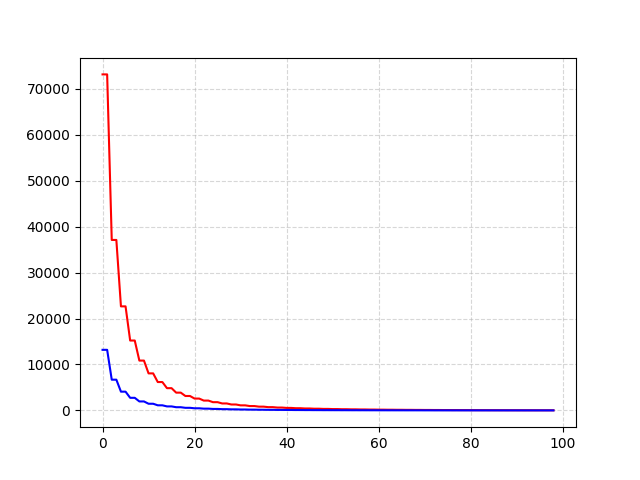

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.grid(True,linestyle='--',alpha=0.5)
plt.plot(list(range(0, k1 -1)), data1, c = 'red')
plt.plot(list(range(0, k2 -1)), data2, c = 'blue')


In [7]:
plt.savefig('梯度法.png')